# HW 3 - Synonym Detection In Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the last homework assignment you performed Naive Bayes to classify documents as 'ham' or 'spam.' In doing so, we relied on the implicit assumption that the list of words in a document can tell us something about the nature of that document's content. We'll rely on a similar intuition this week: the idea that, if we analyze a large enough corpus of text, the list of words that appear in small window before or after a vocabulary term can tell us something about that term's meaning.

This will be your first assignment working in Spark. You'll perform Synonym Detection by repurposing an algorithm commonly used in Natural Language Processing to perform document similarity analysis. In doing so you'll also become familiar with important datatypes for efficiently processing sparse vectors and a number of set similarity metrics (e.g. Cosine, Jaccard, Dice). By the end of this homework you should be able to:  
* ... __define__ the terms `one-hot encoding`, `co-occurrance matrix`, `stripe`, `inverted index`, `postings`, and `basis vocabulary` in the context of both synonym detection and document similarity analysis.
* ... __explain__ the reasoning behind using a word stripe to compare word meanings.
* ... __identify__ what makes set-similarity calculations computationally challenging.
* ... __implement__ stateless algorithms in Spark to build stripes, inverted index and compute similarity metrics.
* ... __apply__ appropriate metrics to assess the performance of your synonym detection algorithm. 


__`NOTE`__: your reading assignment for weeks 5 and 6 were fairly heavy and you may have glossed over the papers on dimension independent similarity metrics by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf) and pairwise document similarity by [Elsayed et al](https://terpconnect.umd.edu/~oard/pdf/acl08elsayed2.pdf). If you haven't already, this would be a good time to review those readings -- they are directly relevant to this assignment.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Spark Basics.
In your readings and live session demos for weeks 4 and 5 you got a crash course in working with Spark. We also talked about how Spark RDDs fit into the broader picture of distributed algorithm design. The questions below cover key points from these discussions. Feel free to answer each one very briefly.

### Q1 Tasks:

* __a) short response:__ What is Spark? How  does it relate to Hadoop MapReduce?

* __b) short response:__ In what ways does Spark follow the principles of statelessness (a.k.a. functional programming)? List at least one way in which it allows the programmer to depart from this principle. 

* __c) short response:__ In the context of Spark what is a 'DAG' and how do they relate to the difference between an 'action' and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?

* __d) short response:__ Give a specific example of when we would want to `cache()` an RDD and explain why.

### Q1 Student Answers:
> __a)__ Apache Spark is an opensource distribution that provides a mechanism for fast and expressive distributed cluster computing framework. Traditional Hadoop MapReduce programs read input data from disk, map a function across the data, reduce the results of the map, and store the results on the disk. Reading or writing to the disk often results in inefficiencies for massive amounts of data. Spark provides mechanisms to store the results in-memory thereby resulting in increased speeds and efficiencies which can sometimes be as high as 100X faster than Hadoop mapreduce. Spark also provides multiple APIs to interface like Java, Scala (Spark was built on Scala), Python and R. Spark's built in libraries for machine learning, graph processing and database management makes it very efficient to write code in less number of lines. 

> __b)__ Functional programming is the process of building software by composing pure functions, avoiding shared state, mutable data, and side-effects. The only access to the data is what the function returns. Spark allows sharing the state through two types of variables, broadcast variable and accumulators. Broadcast variable is a read-only variable cached on each machine that is accesible to every task. Accumulators are type of variables that are added to and can be used for counters/sums. The shared variable concept breaks one principle of functional programming which is side effect (state change that is observable outside the called function).However, Spark maintains the essence of functional programming through higher order functions such as map, reduce and several other functions. 

> __c)__ DAG is Directed Acylic Graph that represents consecutive computation stages. When we write a Spark program, it consists of an RDD from input data, a series of transformations, filters and actions. These are performed in several stages and DAG provides a logical representation of these operations. When a driver runs the program, it converts the logical graph to physical execution plan. Using DAG we can interpret if our Spark code has inefficiencies (multiple stages involving shuffle etc.).  

> __d)__ cache() helps in caching the RDD into memory and helps in faster processing. Spark operations are lazy, which means a given RDD is not accessed until an action is called. In a linear lineage, an RDD is accessed, transformation is performed and the result is used. If we never have a need of accessing the same RDD again, then caching is not needed. However, if our code branches into several functions and each of them is accessing the same RDD several times, caching it helps in speeding things. Cache itself is a lazy operation, i.e, until the first action is called, nothing happens. After an RDD is accessed first time, it is cached so that subsequent calls to the RDD will load the data from the cache. A general rule of thumb is to use cache when we are accessing the RDD multiple times (like in a loop).

Example (From internet):

val textFile = sc.textFile("/user/emp.txt")

val wordsRDD = textFile.flatMap(line => line.split("\\W"))

wordsRDD.cache() <<<<<<<<< Without this, we will load RDD multiple times. 

val positiveWordsCount = wordsRDD.filter(word => isPositive(word)).count()

val negativeWordsCount = wordsRDD.filter(word => isNegative(word)).count() <<<< Accessing same RDD

# Question 2: Similarity Metrics
As mentioned in the introduction to this assignment, an intuitive way to compare the meaning of two documents is to compare the list of words they contain. Given a vocabulary $V$ (feature set) we would represent each document as a vector of `1`-s and `0`-s based on whether or not it contains each word in $V$. These "one-hot encoded" vector representations allow us to use math to identify similar documents. However like many NLP tasks the high-dimensionality of the feature space is a challenge... especially when we start to scale up the size and number of documents we want to compare.

In this question we'll look at a toy example of document similarity analysis. Consider these 3 'documents': 
```
docA	the flight of a bumblebee
docB	the length of a flight
docC	buzzing bumblebee flight
```
These documents have a total of $7$ unique words: 
>`a, bumblebee, buzzing, flight, length, of, the`.     

Given this vocabulary, the documents' vector representations are (note that one-hot encoded entries follow the order of the vocab list above):

```
docA	[1,1,0,1,0,1,1]
docB	[1,0,0,1,1,1,1]
docC	[0,1,1,1,0,0,0]
```  

### Q2 Tasks:

* __a) short response:__ The cosine similarity between two vectors is $\frac{A\cdot B}{|A||B|}$. Explain what the the numerator and denominator of this calculation would represent in terms of word counts in documents A and B. 

* __b) short response:__ Explain how the Jaccard, Overlap and Dice metrics are similar/different to the calculation for cosine similarity. When would these metrics lead to different similarity rankings for a set of documents?

* __c) short response:__ Calculate the cosine similarity for each pair of documents in our toy corpus. Please use markdown and $\LaTeX$ to show your calcuations.  

* __d) short response:__ According to your calculations in `part c` which pair of documents are most similar in meaning? Does this match your expecatation from reading the documents? If not, speculate about why we might have gotten this result.

* __e) short response:__ In NLP common words like '`the`', '`of`', and '`a`' increase our feature space without adding a lot of signal about _semantic meaning_. Repeat your analysis from `part c` but this time ignore these three words in your calculations [__`TIP:`__ _to 'remove' stopwords just ignore the vector entries in columns corresponding to the words you wish to disregard_]. How do your results change?

### Q2 Student Answers:
> __a)__ The numerator is the dot product of vectors A and B. The denominator indicates the arithmetic product of the vector norm of the component vectors A and B. 

> __b)__ The numerator of Cosine, Jaccard, Overlap and Dice are all same and calculates the dot product. The denominator varies for each type. In cosine similarity, the number of common attributes (intersection) is divided by the total number of possible attributes. In Jaccard similarity, common attributes (intersection) is divided by the number of attributes that exists in at least one of the two objects. The Cosine index could be used to identify plagiarism, but will not be a good index to identify mirror sites on the internet. Whereas the Jaccard index, will be a good index to identify mirror sites (Reference : https://datascience.stackexchange.com/questions/5121/applications-and-differences-for-jaccard-similarity-and-cosine-similarity)

> __c)__ 

$docA.docB = 1*1 + 1*0 + 0*0 + 1*1 + 0*1 + 1*1 + 1*1 = 4$

$docA.docC = 1*0 + 1*1 + 0*1 + 1*1 + 0*0 + 1*0 + 1*0 = 2$

$docB.docC = 1*0 + 0*1 + 0*1 + 1*1 + 1*0 + 1*0 + 1*0 = 1$

$||docA|| = \sqrt{1^2+1^2+0^2+1^2+0^2+1^2+1^2} = \sqrt{5}$

$||docB|| = \sqrt{1^2+0^2+0^2+1^2+1^2+1^2+1^2} = \sqrt{5}$

$||docC|| = \sqrt{0^2+1^2+1^2+1^2+0^2+0^2+0^2} = \sqrt{3}$

$cos(docA docB) = \frac{docA.docB}{||docA||*||docB||} = \frac{4}{\sqrt{5}*\sqrt{5}} = \frac{4}{5} = 0.80$

$cos(docA docC) = \frac{docA.docC}{||docA||*||docC||} = \frac{2}{\sqrt{5}*\sqrt{3}} = \frac{2}{\sqrt{15}} = 0.516$

$cos(docB docC) = \frac{docB.docC}{||docB||*||docC||} = \frac{1}{\sqrt{5}*\sqrt{3}} = \frac{1}{\sqrt{15}} = 0.258$


> __d)__ Documents A and B are more similiar according to the cosine similarity calculation. From the sentences, I would have expected documents A and C to be more similar than other combinations. It is likely that the stop words "the","of" and "a" are causing A & B to be more similar.

> __e)__ Ignoring the stop words:

$docA.docB = 1*0 + 0*0 + 1*1 + 0*1 = 1$

$docA.docC = 1*1 + 0*1 + 1*1 + 0*0 = 2$

$docB.docC = 0*1 + 0*1 + 1*1 + 1*0 = 1$

$||docA|| = \sqrt{1^2+0^2+1^2+0^2} = \sqrt{2}$

$||docB|| = \sqrt{0^2+0^2+1^2+1^2} = \sqrt{2}$

$||docC|| = \sqrt{1^2+1^2+1^2+0^2} = \sqrt{3}$

$cos(docA docB) = \frac{docA.docB}{||docA||*||docB||} = \frac{1}{\sqrt{2}*\sqrt{2}} = \frac{1}{2} = 0.50$

$cos(docA docC) = \frac{docA.docC}{||docA||*||docC||} = \frac{2}{\sqrt{2}*\sqrt{3}} = \frac{2}{\sqrt{6}} = 0.816$

$cos(docB docC) = \frac{docB.docC}{||docB||*||docC||} = \frac{1}{\sqrt{2}*\sqrt{3}} = \frac{1}{\sqrt{6}} = 0.408$

After removing the stop words, documents A and C look more similar which is correct observation



## Question 3: Synonym Detection Strategy

In the Synonym Detection task we want to compare the meaning of words, not documents. For clarity, lets call the words whose meaning we want to compare `terms`. If only we had a 'meaning document' for each `term` then we could easily use the document similarity strategy from Question 2 to figure out which `terms` have similar meaning (i.e. are 'synonyms'). Of course in order for that to work we'd have to reasonably believe that the words in these 'meaning documents' really do reflect the meaning of the `term`. For a good analysis we'd also need these 'meaning documents' to be fairly long -- the one or two sentence dictionary definition of a term isn't going to provide enough signal to distinguish between thousands and thousands of `term` meanings.

This is where the idea of co-occurrance comes in. Just like DocSim makes the assumption that words in a document tell us about the document's meaning, we're going to assume that the set of words that 'co-occur' within a small window around our term can tell us some thing about the meaning of that `term`. Remember that we're going to make this 'co-words' list (a.k.a. 'stripe') by looking at a large body of text. This stripe is our 'meaning document' in that it reflects all the kinds of situations in which our `term` gets used in real language. So another way to phrase our assumption is: we think `terms` that get used to complete lots of the same phrases probably have related meanings. This may seem like an odd assumption but computational linguists have found that it works surprisingly well in practice. Let's look at a toy example to build your intuition for why and how.

Consider the opening line of Charles Dickens' _A Tale of Two Cities_:

In [1]:
corpus = """It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness"""

There are a total of 10 unique words in this short 'corpus':

In [7]:
words = list(set(re.findall("\w+", corpus.lower())))
print(words)

['times', 'age', 'wisdom', 'best', 'was', 'worst', 'foolishness', 'the', 'of', 'it']


But of these 10 words, 4 are so common that they probably don't tell us very much about about meaning.

In [8]:
stopwords = ["it", "the", "was", "of"]

So we'll ignore these 'stop words' and we're left with a 6 word vocabulary:

In [9]:
vocab = sorted([w for w in words if w not in stopwords])
print(vocab)

['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


Your goal in the tasks below is to asses, which of these six words are most related to each other in meaning -- based solely on this short two line body of text.

### Q3 Tasks:

* __a) short response:__ Given this six word vocabulary, how many 'pairs' of words do we want to compare? More generally for a n-word vocabulary how many pairwise comparisons are there to make? 

* __b) code:__ In the space provided below, create a 'stripe' for each `term` in the vocabulary. This stripe should be the list of all other vocabulary words that occur within a __5 word window__ of the `term`'s position in the original text.

* __c) code + short response:__ Complete the provided code to turn your stripes into a 1-hot encoded co-occurrence matrix. For our 6 word vocabulary how many entries are in this matrix? How many entries are zeros? 

* __d) code:__ Complete the provided code to loop over all pairs and compute their cosine similarity. Please do not modify the existing code, just add your own in the spot marked.

* __e) short response:__ Which pairs of words have the highest 'similarity' scores? Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'? Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

### Q3 Student Answers:
> __a)__ With 6 words, we will have 15 comparisons in total. For a n-word vocabulary, we will have n*(n-1)/2 pairwise comparisons since we ignore the order.

> __c)__ We have a 6x6 matrix with 36 entries. 26 entries are zeros   

> __e)__ The words ['best','worst'] and ['foolishness','wisdom'] have the highest similarity. They are not synonyms in the traditional sense. They are similar in the sense that they appear most often together in our small corpus. If we had a large corpus, we would probably have a different answer and not an antonym. With large corpus like word2vec, we can form clusters of words that are similar based on their common neighbors.

In [10]:
# for convenience, here are the corpus & vocab list again (RUN THIS CELL AS IS)
print("CORPUS:")
print(corpus)
print('VOCAB:')
print(vocab)

CORPUS:
It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness
VOCAB:
['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


In [11]:
# part b - USE THE TEXT ABOVE TO COMPLETE EACH STRIPE
stripes = {'age':['wisdom','foolishness','times'], # example
           'best':['times'], # YOU FILL IN THE REST
           'foolishness':['age'],
           'times': ['best','worst','age'],
           'wisdom':['age'],
           'worst':['times']}

In [12]:
# part c - initializing an empty co-occurrence matrix (RUN THIS CELL AS IS)
co_matrix = pd.DataFrame({term: [0]*len(vocab) for term in vocab}, index = vocab, dtype=int)

In [16]:
#print(co_matrix)

In [14]:
# part c - FILL IN THE MISSING LINE so that this cell 1-hot encodes the co-occurrence matrix
for term, nbrs in stripes.items():
    for nbr in nbrs:
        pass
        ############# YOUR CODE HERE #################
        co_matrix[term][nbr] = 1
        ############# (END) YOUR CODE #################
co_matrix

,age,best,foolishness,times,wisdom,worst
age,0,0,1,1,1,0
best,0,0,0,1,0,0
foolishness,1,0,0,0,0,0
times,1,1,0,0,0,1
wisdom,1,0,0,0,0,0
worst,0,0,0,1,0,0


In [15]:
# part e - FILL IN THE MISSING LINES to compute the cosine similarity between each pair of terms
for term1, term2 in itertools.combinations(vocab, 2):
    # one hot-encoded vectors
    v1 = co_matrix[term1]
    v2 = co_matrix[term2]
    
    # cosine similarity
    ############# YOUR CODE HERE #################
    v1v2_dot = np.dot(v1,v2)
    v1_norm = np.linalg.norm(v1)
    v2_norm = np.linalg.norm(v2)
    csim = v1v2_dot/(v1_norm*v2_norm)
    ############# (END) YOUR CODE #################    
    
    print(f"{term1}-{term2}: {csim}")

age-best: 0.5773502691896258
age-foolishness: 0.0
age-times: 0.0
age-wisdom: 0.0
age-worst: 0.5773502691896258
best-foolishness: 0.0
best-times: 0.0
best-wisdom: 0.0
best-worst: 1.0
foolishness-times: 0.5773502691896258
foolishness-wisdom: 1.0
foolishness-worst: 0.0
times-wisdom: 0.5773502691896258
times-worst: 0.0
wisdom-worst: 0.0


# Question 4: Pairs and Stripes at Scale

As you read in the paper by Zadeh et al, the advantage of metrics like Cosine, Dice, Overlap and Jaccard is that they are dimension independent -- that is to say, if we implement them in a smart way the computational complexity of performing these computations is independent of the number of documents we want to compare (or in our case, the number of terms that are potential synonyms). One component of a 'smart implementation' involves thinking carefully both about how you define the "basis vocabulary" that forms your feature set (removing stopwords, etc). Another key idea is to use a data structure that facilitates distributed calculations. The DISCO implemetation further uses a sampling strategy, but that is beyond the scope of this assignment. 

In this question we'll take a closer look at the computational complexity of the synonym detection approach we took in question 3 and then revist the document similarity example as a way to explore a more efficient approach to parallelizing this analysis.

### Q4 Tasks:

* __a) short response:__ In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences in a corpus. Imagine for now that you have unlimited memory on each of your nodes and describe a sequence of map & reduce steps that would start from a raw corpus and reproduce your strategy from Q3. Be specific. For each step be sure to note what information would be stored in memory on your nodes and what information would need to be shuffled over the network. 

* __b) short response:__ In the asynch videos about "Pairs and Stripes" you were introduced to an alternative strategy. Explain two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to distributed similarity calculations [__`HINT:`__ _Consider memory constraints, amount of information being shuffled, amount of information being transfered over the network, and level of parallelization._]

* __c) read provided code:__ The code below provides a streamined implementation of Document similarity analysis in Spark. Read through this code carefully. Once you are confident you understand how it works, answer the remaining questions. [__`TIP:`__ _to see the output of each transformation try commenting out the subsequent lines and adding an early `collect()` action_.]

* __d) short response:__ The second mapper function, `splitWords`, emits 'postings'. The list of all 'postings' for a word is also refered to as an 'inverted index'. Define each of these terms based on your reading of the provided code.

* __e) short response:__ The third mapper, `makeCompositeKeys`, loops over the inverted index to emit 'pairs' of what? Explain what information is included in the composite key created at this stage and why it makes sense to synchronize around that information in the context of performing document similarity calculations. In addition to the information included in these new keys, what other piece of information will we need to compute Jaccard or Cosine similarity?

* __f) short response:__ Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which are 'narrow' transformations. Explain.

### Q4 Student Answers:
> __a)__ I would attempt a  Hadoop MR job as below:

* Mappers  : Input is raw corpus of documents. Output of each mapper is in the form of Word and document id - ex: W1:{docA}
* Shuffle : The mapper outputs above will be shuffled with word as key
* Reducers : Aggregate word as key and build a final list of each word - ex: W1:{docA,docC,docD},W2:{docA,docB} and convert it to one-hot format. The output in one-hot format is W1:{1,0,1,0,0...}
* Mappers : Send the output of the previous result from the reducer to another set of mappers which will emit pair-wise one-hot vector. ex: W1,W2 : {1,0,1,0,0..}{1,1,0,0,0..}
* Shuffle : Sort by word pair and send to a reducer
* Reducer (single) : Compute similarity from the one-hot vectors recieved from all the pairs. 

> __b)__ The alternative approach to pairs is stripes model. For example, instead of the pairs approach above, we should emit in the format word and its neighbors: W1:{'W2','W3',..}, W2:{'W1','W4',..} etc. The reducers can construct the one-hot encoded vectors from the stripes as shown in Q3 and calculate the cosine similarity.

> __c)__ _read provided code before answering d-f_ 

> __d)__ The mapper splitWords emits a word and its location (document ID). We can view 'posting' as a document_index where a given word is present. List of such postings is refered as as inverted index. Refering to our example below, an inverted index for 'bright' is [docA,docB,docC] where each document is a posting. This is 'inverted' because the other form is to have a documennt as key and words present as values.  

> __e)__ makeCompsiteKeys emits pairs of "documents" that contain common words. From the postings of words, we can find pair of documents that contain same word and emit such pairs. We can then aggregate these counts for every pair. At the end of the reduction step (reduceByKey), we have pair of documents with number of common words between them and also individual word total per each document.This information is good enough to construct the vectors and compute jaccard/cosine similarities. 

> __f)__ map,flatMap are narrow transformations as they operate only on individual elements. reduceByKey and takeOrdered are wide transformations as they need the entire RDD to perform the aggregation (reduceByKey) and ordering across the partitions.

A small test file: __`sample_docs.txt`__

In [5]:
%%writefile sample_docs.txt
docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly

Overwriting sample_docs.txt


__Document Similarity Analysis in Spark:__

In [18]:
# load data - RUN THIS CELL AS IS
data = sc.textFile("sample_docs.txt")  

In [19]:
# helper function - RUN THIS CELL AS IS
def splitWords(pair):
    """Mapper 2: tokenize each document and emit postings."""
    doc, text = pair
    words = text.split(" ")
    for w in words:
        yield (w, [(doc,len(words))])

In [20]:
# helper function - RUN THIS CELL AS IS
def makeCompositeKey(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

In [21]:
# helper function - RUN THIS CELL AS IS
def jaccard(line):
    """Mapper 4: compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    yield doc1+" - "+doc2, jaccard

In [23]:
rdd1 = data.map(lambda line: line.split('\t'))
rdd2 = rdd1.flatMap(splitWords)
rdd2.collect()

[('bright', [('docA', 4)]),
 ('blue', [('docA', 4)]),
 ('butterfly', [('docA', 4)]),
 ('forget', [('docA', 4)]),
 ('best', [('docB', 4)]),
 ('forget', [('docB', 4)]),
 ('bright', [('docB', 4)]),
 ('sky', [('docB', 4)]),
 ('blue', [('docC', 4)]),
 ('sky', [('docC', 4)]),
 ('bright', [('docC', 4)]),
 ('sun', [('docC', 4)]),
 ('under', [('docD', 4)]),
 ('butterfly', [('docD', 4)]),
 ('sky', [('docD', 4)]),
 ('hangs', [('docD', 4)]),
 ('forget', [('docE', 3)]),
 ('blue', [('docE', 3)]),
 ('butterfly', [('docE', 3)])]

In [24]:
rdd3 = rdd2.reduceByKey(lambda x,y : x+y)
rdd3.collect()

[('bright', [('docA', 4), ('docB', 4), ('docC', 4)]),
 ('butterfly', [('docA', 4), ('docD', 4), ('docE', 3)]),
 ('best', [('docB', 4)]),
 ('sky', [('docB', 4), ('docC', 4), ('docD', 4)]),
 ('sun', [('docC', 4)]),
 ('blue', [('docA', 4), ('docC', 4), ('docE', 3)]),
 ('forget', [('docA', 4), ('docB', 4), ('docE', 3)]),
 ('under', [('docD', 4)]),
 ('hangs', [('docD', 4)])]

In [25]:
rdd4 = rdd3.flatMap(makeCompositeKey)
rdd4.collect()

[("(('docA', 4), ('docB', 4))", 1),
 ("(('docA', 4), ('docC', 4))", 1),
 ("(('docB', 4), ('docC', 4))", 1),
 ("(('docA', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 1),
 ("(('docD', 4), ('docE', 3))", 1),
 ("(('docB', 4), ('docC', 4))", 1),
 ("(('docB', 4), ('docD', 4))", 1),
 ("(('docC', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docC', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 1),
 ("(('docC', 4), ('docE', 3))", 1),
 ("(('docA', 4), ('docB', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 1),
 ("(('docB', 4), ('docE', 3))", 1)]

In [26]:
rdd5 = rdd4.reduceByKey(lambda x,y : x+y)
rdd5.collect()

[("(('docA', 4), ('docB', 4))", 2),
 ("(('docA', 4), ('docC', 4))", 2),
 ("(('docB', 4), ('docC', 4))", 2),
 ("(('docD', 4), ('docE', 3))", 1),
 ("(('docC', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 3),
 ("(('docB', 4), ('docD', 4))", 1),
 ("(('docC', 4), ('docE', 3))", 1),
 ("(('docB', 4), ('docE', 3))", 1)]

In [22]:
# Spark Job - RUN THIS CELL AS IS
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
             .takeOrdered(10, key=lambda x: -x[1])
result

[('docA - docE', 0.75),
 ('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docB - docC', 0.3333333333333333),
 ('docD - docE', 0.16666666666666666),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666),
 ('docC - docD', 0.14285714285714285),
 ('docA - docD', 0.14285714285714285),
 ('docB - docD', 0.14285714285714285)]

# About the Data
Now that you are comfortable with similarity metrics we turn to the main task in this assignment: Synonym Detection. As you saw in Question 3 the ability of our algorithm to detect words with similar meanings is highly dependent on our input text. Specifically, we need a large enough corpus of natural language that we can expose our algorithm to a realistic range of contexts in which in any given word might get used. Ideally, these 'contexts' would also provide enough signal to distinguish between words with similar semantic roles but different meaning. Finding such a corpus will be easier to accomplish for some words than others.

For the main task in this portion of the homework you will use data from Google's n-gram corpus. This data is particularly convenient for our task because Google has already done the first step for us: they windowed over a large subset of the web and extracted all 5-grams. If you are interested in learning more about this dataset the original source is: http://books.google.com/ngrams/, and a large subset is available [here from AWS](https://aws.amazon.com/datasets/google-books-ngrams/). 

For this assignment we have provided a subset of the 5-grams data consisting of 191 files of approximately 10MB each. These files are available on dropbox at: https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea
... below we provide the code to download these files. Please only use the provided data so that we can ensure consistent results from student to student.

Each row in our dataset represents one of these 5 grams in the format:
> `(ngram) \t (count) \t (pages_count) \t (books_count)`

__DISCLAIMER__: In real life, we would calculate the stripes cooccurrence data from the raw text by windowing over the raw text and not from the 5-gram preprocessed data.  Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms. 

In [6]:
!mkdir data

In [7]:
# download the zipped data folder - RUN THIS CELL AS IS
!curl -L -o ngrams.zip https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100  829M    0  829M    0     0   782k      0 --:--:--  0:18:05 --:--:--  876k


In [8]:
# unzip the data files into the data directory - RUN THIS CELL AS IS
!unzip -q ngrams.zip -d data

mapname:  conversion of  failed


In [5]:
# set global paths to full data folder and to the first file (which we'll use for testing)
NGRAMS = PWD + '/data'
F1_PATH = PWD + '/data/googlebooks-eng-all-5gram-20090715-0-filtered.txt'

As you develop your code you should use the following file to systems test each of your solutions before running it on the Google data. (Note: these are the 5-grams extracted from our two line Dickens corpus in Question 3... you should find that your Spark job results match the calculations we did "by hand").

Test file: __`systems_test.txt`__

In [6]:
%%writefile systems_test.txt
it was the best of	1	1	1
age of wisdom it was	1	1	1
best of times it was	1	1	1
it was the age of	2	1	1
it was the worst of	1	1	1
of times it was the	2	1	1
of wisdom it was the	1	1	1
the age of wisdom it	1	1	1
the best of times it	1	1	1
the worst of times it	1	1	1
times it was the age	1	1	1
times it was the worst	1	1	1
was the age of wisdom	1	1	1
was the best of times	1	1	1
was the age of foolishness	1	1	1
was the worst of times	1	1	1
wisdom it was the age	1	1	1
worst of times it was	1	1	1

Overwriting systems_test.txt


Finally, we'll create a Spark RDD for each of these files so that they're easy to access throughout the rest of the assignment.

In [6]:
# Spark RDDs for each dataset
testRDD = sc.textFile("systems_test.txt") 
f1RDD = sc.textFile(F1_PATH)
dataRDD = sc.textFile(NGRAMS)

Let's take a peak at what each of these RDDs looks like:

In [12]:
testRDD.take(10)

['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 'it was the worst of\t1\t1\t1',
 'of times it was the\t2\t1\t1',
 'of wisdom it was the\t1\t1\t1',
 'the age of wisdom it\t1\t1\t1',
 'the best of times it\t1\t1\t1',
 'the worst of times it\t1\t1\t1']

In [13]:
f1RDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

In [14]:
dataRDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

# Question 5: N-gram EDA part 1 (words)

Before starting our synonym-detection, let's get a sense for this data. As you saw in questions 3 and 4 the size of the vocabulary will impact the amount of computation we have to do. Write a Spark job that will accomplish the three tasks below as efficiently as possible. (No credit will be awarded for jobs that sort or subset after calling `collect()`-- use the framework to get the minimum information requested). As you develop your code, systems test each job on the provided file with Dickens ngrams, then on a single file from the Ngram dataset before running the full analysis.


### Q5 Tasks:
* __a) code:__ Write a Spark job to retrieve:
  * The number of unique words that appear in the data. (i.e. size of the vocabulary) 
  * A list of the top 10 words & their counts.
  * A list of the bottom 10 words & their counts.  
  
  __`NOTE  1:`__ _don't forget to lower case the ngrams before extracting words._  
  __`NOTE  2:`__ _don't forget to take in to account the number of occurances of each ngram._  
  __`NOTE  3:`__ _to make this code more reusable, the `EDA1` function code base uses a parameter 'n' to specify the number of top/bottom words to print (in this case we've requested 10)._


* __b) short response:__ Given the vocab size you found in part a, how many potential synonym pairs could we form from this corpus? If each term's stripe were 1000 words long, how many individual 'postings' tuples would we need to shuffle inorder to form the inverted indices? Show and briefly explain your calculations for each part of this question. [__`HINT:`__ see your work from q4 for a review of these concepts.]

* __c) short response:__ What do you notice about the most frequent words, how usefull will these top words be in synonym detection? Explain.

* __d) short response:__ What do you notice/infer about the least frequent words, how reliable should we expect the detected 'synonyms' for the bottom words to be? Explain.

### Q5 Student Answers:

> __b)__ If we were to compare every word against other, we will have $269339*269338/2 = 36.27Million$ synonym pairs using the formula $n*(n-1)/2$. We have 1000 BASIS words, and 'N' vocab size. Assuming worst case scenario where every VOCAB word (doc) has all 1000 neighbors (which will be the case if our BASIS is most frequent words), we will have 1000xN individual postings tuples that needs to be shuffled. This translates to $269339*1000=269.34Million$. But I am assuming that not every word (doc) will have all 1000 BASIS words as neighbors. So the answer should be less than 1000xN

> __c)__ The most frequent words are common words (Stop words). These are not useful in synonym detection and will impact our results negatively.  

> __d)__ Least frequent words will have fewer neighbors (since they occur very less). So the result of synonym might be less reliable given they occur very rarely.

In [8]:
# part a - write your spark job here 
def splitWords_new(line):
    """Slight modification of the splitWords from Q4"""
    ngram,count,pages_count,books_count = line
    words = ngram.lower().split(" ")
    # Loop through each word and return their count
    # Since we have ngram count, it also adds to the word count
    # We can aggregate the word count in reduce function later
    for w in words:
        yield (w, int(count))
        
def EDA1(rdd, n):
    total, top_n, bottom_n = None, None, None
    ############# YOUR CODE HERE ###############
    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(splitWords_new) \
             .reduceByKey(lambda x,y : x+y) \
    
    # Number of unique words
    total = result.count()
    # Sort for top 'n'
    top_n = result.takeOrdered(n, key=lambda x: -x[1])
    # Sort for bottm 'n'
    bottom_n = result.takeOrdered(n, key=lambda x: x[1])
    
    #return result
    ############# (END) YOUR CODE ##############
    return total, top_n, bottom_n


In [9]:
#temp = EDA1(testRDD,10)
#temp.collect()

In [11]:
# part a - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.4178330898284912 seconds


In [12]:
# part a - run a single file (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 2.1878695487976074 seconds


In [14]:
# part a - run full analysis (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 182.84127140045166 seconds


In [24]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |     foretastes  40
      of 3698583299 |       parcival  40
      to 2227866570 |   schwetzingen  40
      in 1421312776 |           cras  40
       a 1361123022 |      scholared  40
     and 1149577477 |    scribbler's  40
    that  802921147 |      washermen  40
      is  758328796 |    viscerating  40
      be  688707130 |    unmurmuring  40
      as  492170314 |         mildes  40


__Expected output:__  
_(bottom words might vary a little due to ties)._
<table>
<th>Top Words</th>
<th>Bottom Words</th>
<tr><td><pre>
the 5490815394
of 3698583299
to 2227866570
in 1421312776
a 1361123022
and 1149577477
that  802921147
is  758328796
be  688707130
as  492170314
</pre></td>
<td><pre>
foretastes  40
parcival  40
schwetzingen  40
cras  40
 scholared  40
scribbler's  40
washermen  40
viscerating  40
unmurmuring  40
mildes  40
</pre></td></tr>
</table>

# Question 6: N-gram EDA part 2 (co-occurrences)

The computational complexity of synonym analysis depends not only on the number of words, but also on the number of co-ocurrences each word has. In this question you'll take a closer look at that aspect of our data. As before, please test each job on small "systems test" (Dickens ngrams) file and on a single file from the Ngram dataset before running the full analysis.

### Q6 Tasks:
* __a) code:__ Write a spark job that computes:
  * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary. 
  * the top 10 words with the most "neighbors"
  * the bottom 10 words with least "neighbors"
  * a random sample of 1% of the words' neighbor counts  
  __`NOTE:`__ for the last item, please return only the counts and not the words -- we'll go on to use these in a plotting function that expects a list of integers.


* __b) short response:__ Use the provided code to plot a histogram of the sampled list from `a`. Comment on the distribution you observe. How will this distribution affect our synonym detection analysis?

* __c) code + short response:__ Write a Spark Job to compare the top/bottom words from Q5 and from part a. Specifically, what % of the 1000 most/least neighbors words also appear in the list of 1000 most/least frequent words. [__`NOTE:`__ _technically these lists are short enough to comparing in memory on your local machine but please design your Spark job as if we were potentially comparing much larger lists._]

### Q6 Student Answers:

> __b)__ The distribution is heavily skewed towards small number of words that has lot of neighbors (must be stop words like "the","a","was" etc.). There is a long tail with words which has fewer neighbors. Stop words will have a huge affect in our synonym detection analysis

> __c)__ Taking from the dataRDD : Of the 1000 words with most neighbors, 88.0 percent are also in the list of 1000 most frequent words. Of the 1000 words with least neighbors, 1.9 percent are also in the list of 1000 least frequent words.

   

In [30]:
# part a - spark job

def wordNeighbors_Comb(line):
    """Return word and its neighbors uaing combinations"""
    # This procedure worked but used the below:
    ngram,count,pages_count,books_count = line
    words = ngram.lower().split(" ")
    # Loop through each word and return the neighbor
    # TBD : Use Combinations
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(words, 2):
        yield (subset)

def wordNeighbors(line):
    """Return word and its neighbors"""
    ngram,count,pages_count,books_count = line
    words = ngram.lower().split(" ")
    # Loop through each word and return the neighbor
    # TBD : Use Combinations
    for w in words:
        for neighbor in words:
            if w != neighbor:
                yield (w, (neighbor))

def emitReverse(pair):
    """ When using combinations, we need to take care of reverse"""
    for subset in itertools.permutations(pair, 2):
        yield (subset)

    
def wordCount(stripe):
    """ Return word count"""
    word,neighbors = stripe
    yield (word,len(neighbors.split()))
  

def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############
    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(wordNeighbors) \
             .distinct() \
             .reduceByKey(lambda x,y : x+' '+y) \
             .flatMap(wordCount)
    
    top_n = result.takeOrdered(n, key=lambda x: -x[1])
    bottom_n = result.takeOrdered(n, key=lambda x: x[1])
    result_sample = result.sample(False, 0.01)
    sampled_counts = result_sample.map(lambda word: word[1]).collect()
    
    
    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [28]:
#temp = EDA2_old(f1RDD,10)
#temp.collect()

In [31]:
# part a - systems test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.4241013526916504 seconds


In [32]:
# part a - single file test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 18.388945817947388 seconds


In [33]:
# part a - full data (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 1752.0726170539856 seconds


In [34]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1


__Part a expected output:__  
_(bottom words might vary a little due to ties)._
<table>
<th>Most Neighbors</th>
<th>Least Neighbors</th>
<tr><td><pre>
the   164982 
of   155708 
and   132814 
in   110615 
to    94358 
a    89197
by    67266
with    65127
that    61174
as    60652
</pre></td>
<td><pre>
cococo    1
inin    1
charuhas    1
ooooooo    1
iiiii    1
iiiiii    1
cnj    1
choh    1
neg    1
cococococo    1
</pre></td></tr>
</table>

__`NOTE:`__ _before running the plotting code below, make sure that the variable_ `sample_counts` _points to the list generated in_ `part a`.

NOTE: we'll exclude the 8 words with more than 6000 nbrs in this 2667 count sample.


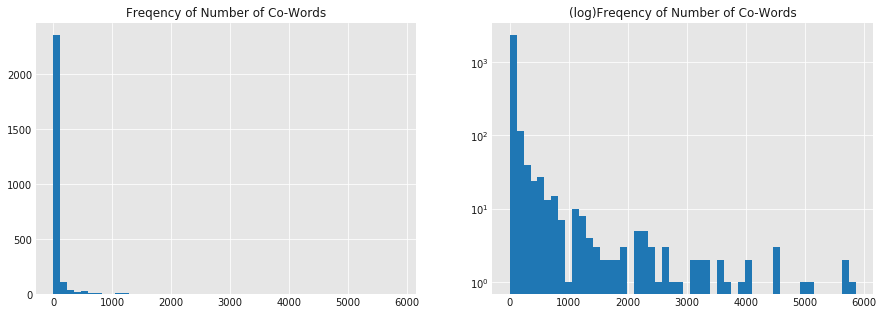

In [55]:
# part b - plot histogram (RUN THIS CELL AS IS - feel free to modify format)

# removing extreme upper tail for a better visual
counts = np.array(sample_counts)[np.array(sample_counts) < 6000]
t = sum(np.array(sample_counts) > 6000)
n = len(counts)
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(counts, bins=50)
ax1.set_title('Freqency of Number of Co-Words', color='0.1')
ax1.set_facecolor('0.9')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

# plot log scale hist
ax2.hist(counts, bins=50)
ax2.set_title('(log)Freqency of Number of Co-Words', color='0.1')
ax2.set_facecolor('0.9')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)
plt.yscale('log')

plt.show()

In [11]:
# part c - spark job
def compareRankings(rdd1, rdd2):
    percent_overlap = None
    ############# YOUR CODE HERE ###############
    rdd_overlap = rdd1.join(rdd2)
    overlap_count = rdd_overlap.count()
    percent_overlap = overlap_count*100.0/1000.0

    ############# (END) YOUR CODE ##############
    return percent_overlap

In [83]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(dataRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(dataRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 88.0 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 1.9 percent are also in the list of 1000 least frequent words.


# Question 7: Basis Vocabulary & Stripes

Every word that appears in our data is a potential feature for our synonym detection analysis. However as we've discussed, some are likely to be more useful than others. In this question, you'll choose a judicious subset of these words to form our 'basis vocabulary' (i.e. feature set). Practically speaking, this means that when we build our stripes, we are only going to keep track of when a term co-occurs with one of these basis words. 


### Q7 Tasks:
* __a) short response:__ Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does this choice relate to the ideas of 'overfitting' or 'underfitting' a training set?

* __b) short response:__ If we had a much larger dataset, computing the full ordered list of words would be extremely expensive. If we need to none-the-less get an estimate of word frequency in order to decide on a basis vocabulary (feature set), what alternative strategy could we take?

* __c) code:__ Write a spark job that does the following:
  * tokenizes, removes stopwords and computes a word count on the ngram data
  * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)
  * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
  (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)
  * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  
  
  __NOTE:__ _to ensure consistency in results please use only the provided list of stopwords._  
  __NOTE:__ _as always, be sure to test your code on small files as you develop it._  

* __d) code:__ Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data using the basis vocabulary you developed in `part c`. This job/function, unlike others so far, should return an RDD (which we will then use in q8).

### Q7 Student Answers:
> __a)__ Since most frequent words will have a tendency to co-occur with many terms, we will end up with wrong synonyms, just like how we got antonyms as synonyms in Q3e. I would consider using most frequent words as overfitting. If we use less frequent words as vocab, we may have some words that may not have any neighbors associated with the BASIS vocab. So, we will have less synonyms and some words may not return any synonym. In my view, this is similar to underfitting (too few useful features). 

> __b)__ If we have much larger dataset, we can randomly pick a sample based on the number of occurences, removing the words which occur say <3 times etc. Since we generally have a long tail of occurences, having such a randomized strategy to pick words would still give us accurate results.


In [12]:
# part c - provided stopwords (RUN THIS CELL AS IS)
STOPWORDS =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 'should', 'can', 'now', 'will', 'just', 
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

In [40]:
# part c - spark job

def splitWords_new(line):
    """Same from previous question"""
    ngram,count,pages_count,books_count = line
    words = ngram.lower().split(" ")
    # Loop through each word and return their count
    # Since we have ngram count, it also adds to the word count
    # We can aggregate the word count in reduce function later
    for w in words:
        yield (w, int(count))

def get_vocab(rdd, n_total, n_basis):
    vocab, basis = None, None
    ############# YOUR CODE HERE ###############
    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(splitWords_new) \
             .filter(lambda x: x[0] not in STOPWORDS) \
             .reduceByKey(lambda x,y : x+y)

    # Now get the vocab list of size n_total
    top_word_count = result.takeOrdered(n_total, key=lambda x: -x[1])
    # Build the vocab
    vocab = [x[0] for x in top_word_count]
    # Build the basis
    basis  = vocab[n_total - n_basis:]
    ############# (END) YOUR CODE ##############
    return vocab, basis


In [41]:
# part c - run your job (replace 'testRDD' with 'f1RDD'/'dataRDD' when ready)
VOCAB, BASIS = get_vocab(testRDD, 10, 5)

In [42]:
print("VOCAB\n")
print(VOCAB)
print("\nBASIS\n")
print(BASIS)

VOCAB

['times', 'age', 'worst', 'wisdom', 'best', 'foolishness']

BASIS

['foolishness']


In [56]:
# part c - run your job (replace 'testRDD' with 'f1RDD'/'dataRDD' when ready)
VOCAB, BASIS = get_vocab(dataRDD, 10000, 1000)

In [57]:
# part c - save to file (RUN THIS CELL AS IS)
with open("vocabulary.txt", "w") as file:
    file.write(str(VOCAB))
with open("basis.txt", "w") as file:
    file.write(str(BASIS))

In [59]:
# part d - spark job

def wordNeighbors(line):
    """Return word and its neighbors. Reuse from earlier with modification"""
    ngram,count,pages_count,books_count = line
    words = ngram.lower().split(" ")
    # Loop through each word and return the neighbor
    # We will also check for STOP WORDS
    for w in words:
        for neighbor in words:
            if w not in STOPWORDS and neighbor not in STOPWORDS:
                if w != neighbor:
                    yield (w, (neighbor))

def vocab_check(line,vocab,basis):
    """ Check if the neighbor is in the basis vocab"""
    word,neighbor = line
    # We only took 10000 words in vocab. So we check if the word is in vocab
    if word in vocab and neighbor in basis:
        yield((word,neighbor))

def wordCount(stripe):
    """ Return word count"""
    word,neighbors = stripe
    yield (word,len(neighbors.split()))

def buildStripes(rdd, vocab, basis):
    stripesRDD = None
    ############# YOUR CODE HERE ###############
    stripesRDD = rdd.map(lambda line: line.split('\t')) \
                    .flatMap(wordNeighbors) \
                    .distinct() \
                    .flatMap(lambda line: vocab_check(line, vocab, basis)) \
                    .reduceByKey(lambda x,y : x+'\t'+y) \
                    .map(lambda line: (line[0], line[1].split('\t')))
                    
    ############# (END) YOUR CODE ##############
    return stripesRDD

In [55]:
# part d - run your systems test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(testRDD, 10, 10)
testStripesRDD = buildStripes(testRDD, VOCAB, BASIS)
start = time.time()
testStripesRDD.top(10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.2614128589630127 seconds


In [47]:
# part d - run your single file test (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open("basis.txt", "r").read())
f1StripesRDD = buildStripes(f1RDD, VOCAB, BASIS)
start = time.time()
f1StripesRDD.top(5)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 28.35669469833374 seconds


In [60]:
# part d - run the full analysis (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open("basis.txt", "r").read())
stripesRDD = buildStripes(dataRDD, VOCAB, BASIS).cache()

In [61]:
#stripesRDD.top(3)

In [62]:
# part d - take a look at a few stripes (RUN THIS CELL AS IS)
start = time.time()
for wrd, stripe in stripesRDD.top(3):
    print(wrd)
    print(list(stripe))
    print('-------')
print("Wall time: {} seconds".format(time.time() - start))

zones
['gaza', 'remotest', 'adhesion', 'residential', 'subdivided', 'warmer', 'environments', 'saturation', 'localities', 'parks', 'uppermost', 'buffer']
-------
zone
['intervening', 'uppermost', 'au', 'masculine', 'trigger', 'originate', 'residential', 'traversed', 'unusually', 'articular', 'avoidance', 'americas', 'parked', 'auxiliary', 'guides', 'poorly', 'excitation', 'flexor', 'contamination', 'atlas', 'cartilage', 'fibrous', 'tribal', 'vomiting', 'sandy', 'alaska', 'ie', 'glowing', 'illuminated', 'penis', 'accumulate', 'assisting', 'saturation', 'penetrating', 'persia', 'southeastern', 'defines', 'diffuse', 'buffer', 'inorganic', 'turbulent', 'cracks', 'subdivided', 'officially', 'transitional', 'narrower']
-------
zinc
['weighing', 'ammonium', 'dysfunction', "alzheimer's", 'pancreas', 'dipped', 'radioactive', 'dietary', 'coating', 'phosphorus', 'insoluble', 'burns', 'leukemia', 'wasting', 'metallic', 'transcription', 'hydroxide', 'diamond']
-------
Wall time: 1980.0946807861328 

In [64]:
# part d - save your full stripes to file for ease of retrival later... (OPTIONAL)
stripesRDD.saveAsTextFile(PWD + '/stripes')

# Question 8: Synonym Detection

We're now ready to perform the main synonym detection analysis. In the tasks below you will compute cosine, jaccard, dice and overlap similarity measurements for each pair of words in our vocabulary and then sort your results to find the most similar pairs of words in this dataset. __`IMPORTANT:`__ When you get to the sorting step please __sort on cosine similarity__ only, so that we can ensure consistent results from student to student. 

Remember to test each step of your work with the small files before running your code on the full dataset. This is a computationally intense task: well designed code can be the difference between a 20min job and a 2hr job. __`NOTE:`__ _as you are designing your code you may want to review questions 3 and 4 where we modeled some of the key pieces of this analysis._

### Q8 Tasks:
* __a) short response:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning. What is the 'feature space' for this representation? (i.e. what are the features of our 1-hot encoded vectors?). What is the maximum length of a stripe?

* __b) short response:__ Remember that we are going to treat these stripes as 'documents' and perform similarity analysis on them. The first step is to emit postings which then get collected to form an 'inverted index.' How many entries will there be in our inverted index? Explain.

* __c) short response:__ In the demo from question 2, we were able to compute the cosine similarity directly from the stripes (we did this using their vector form, but could have used the list instead). So why do we need the inverted index? (__`HINT:`__ _see your answer to Q4a & Q4b_)

* __d) code:__ Write a spark job that does the following:
  * loops over the stripes from Q7 and emits postings for the `term` (_remember stripe = document_)
  * aggregates the postings to create an inverted index
  * loops over all pairs of `term`s that appear in the same inverted index and emits co-occurrence counts
  * aggregates co-occurrences
  * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and overlap similarity metrics for each pair of words in the vocabulary 
  * retrieve the top 20 and bottom 20 most/least similar pairs of words
  * also returned the cached sorted RDD for use in the next question  
  __`NOTE 1`:__ _Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. A composite key is the way to go here._  
  __`NOTE 2`:__ _Please make sure that your final results are sorted according to cosine similarity otherwise your results may not match the expected result & you will be marked wrong._
  
* __e) code:__ Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything odd about these pairs of words? Discuss at least one idea for how you might go about improving on the analysis.

### Q8 Student Answers:
> __a)__ The feature space is the basis vocabulary we used. The max length of the stripe is the size of basis (1000 in the example of Q7). Each stripe's length is the number of neighbors it has from BASIS.

> __b)__ Our inverted index will have the form of feature: postings, and the length of inverted index is the length of postings. The number of entries depend on the number of terms (doc) each feature has as its neighbor. Giving an example:
stripes 'extreme', 'anthopological','note' etc all have 'commonplace' as neighbor. So, when we build inverted index for 'commonplace', its postings will have terms 'extreme', 'anthopological','note' etc.

> __c)__ Inverted index helps us to simplify and speed up the computation of similarity index. With inverted index representation, spark can do the aggregation counts for similarity without waiting for complete shuffle to happen. With stripes approach, we cannot compute similarity between two terms without shuffle unless they are in the same partition.

> __e)__ Most similar pairs seem to be good in terms of co-occuring but they are not exactly synonyms. For example, 'time' seem to have lot of synonyms like 'first','well','way','new'. We have to filter out common words beyond the STOPWORDS to get more meaningful synonyms. 


In [32]:
# helper function for pretty printing (RUN THIS CELL AS IS)
def displayOutput(lines):
    template = "{:25}|{:6}, {:7}, {:7}, {:5}"
    print(template.format("Pair", "Cosine", "Jaccard", "Overlap", "Dice"))
    for line in lines:
        pair = line[0]
        scores = line[1:]
        scores = [round(s,4) for s in scores]
        print(template.format(pair, *scores))

__`TIP:`__ Feel free to define helper functions within the main function to help you organize your code. Readability is important! Eg:
```
def similarityAnlysis(stripesRDD):
    """main docstring"""
    
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############ YOUR CODE HERE ###########
    def helper1():
        """helper docstring"""
        return x
        
    def helper2():
        """helper docstring"""
        return x
        
    # main spark job starts here
    
        ...etc
    ############ (END) YOUR CODE ###########
    return simScoresRDD, top_n, bottom_n
```


In [51]:
# part d - write your spark job in the space provided
def EmitPostings(stripe):
    """ Emit postings from wordpair"""
    # Split stripe into doc and features
    # Here doc is the word where we are interested in finding similarity
    # Features are the partial vocabulary we got from BASIS 
    doc,features = stripe
    for f in features:
        yield (f,[(doc,len(features))])

def makeCompositeKey(inverted_index):
    """Loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

def ComputeSimilarities(line):
    """Compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    dice = total * 2.0 / float(int(n1) + int(n2))
    overlap = total * 1.0 / min(int(n1), int(n2))
    csim = total / float(np.sqrt(int(n1)) * np.sqrt(int(n2))) 
    
    yield (doc1+" - "+doc2, csim, jaccard, overlap, dice)
    
def similarityAnalysis(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############### YOUR CODE HERE ################
    result = stripesRDD.flatMap(EmitPostings) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(ComputeSimilarities).cache() 
    
    top_n = result.takeOrdered(n, key=lambda x: -x[1])
    bottom_n = result.takeOrdered(n, key=lambda x: x[1])

    ############### (END) YOUR CODE ##############
    return result, top_n, bottom_n

In [67]:
## Test.. Remove before submission
    
def TestForRDD(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############### YOUR CODE HERE ################
    result = stripesRDD.flatMap(EmitPostings) \
             .reduceByKey(lambda x,y : x+y)
    return result

#test_rdd = TestForRDD(stripesRDD,20)
#test_rdd.take(1)

In [24]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
testResult, top_n, bottom_n = similarityAnalysis(testStripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.5325150489807129 seconds


In [25]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
f1Result, top_n, bottom_n = similarityAnalysis(f1StripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 1.0342168807983398 seconds


In [52]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
result, top_n, bottom_n = similarityAnalysis(stripesRDD, 20)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 813.2700440883636 seconds


In [33]:
#result.top(3)

In [53]:
# part d - display the results (RUN THIS CELL AS IS)
print("MOST SIMILAR:")
displayOutput(top_n)
print("")
print("LEAST SIMILAR:")
displayOutput(bottom_n)

MOST SIMILAR:
Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,  

__Expected output:__  
<table>
<th>Most Similar</th>
<th>Least Similar</th>
<tr><td><pre>
Pair           |Cosine, Jaccard, Overlap, Dice 
first - time   |  0.89,  0.8012,  0.9149, 0.8897
time - well    |0.8895,   0.801,   0.892, 0.8895
great - time   | 0.875,  0.7757,   0.925, 0.8737
part - well    | 0.874,  0.7755,  0.9018, 0.8735
first - well   |0.8717,  0.7722,  0.8936, 0.8715
part - time    |0.8715,  0.7715,  0.9018, 0.871
time - upon    |0.8668,   0.763,  0.9152, 0.8656
made - time    | 0.866,  0.7619,  0.9109, 0.8649
made - well    |0.8601,  0.7531,  0.9022, 0.8592
time - way     |0.8587,  0.7487,  0.9259, 0.8563
great - well   |0.8526,  0.7412,  0.8988, 0.8514
time - two     |0.8517,  0.7389,  0.9094, 0.8498
first - great  |0.8497,  0.7381,  0.8738, 0.8493
first - part   |0.8471,  0.7348,  0.8527, 0.8471
great - upon   |0.8464,  0.7338,  0.8475, 0.8464
upon - well    |0.8444,   0.729,   0.889, 0.8433
new - time     |0.8426,   0.724,  0.9133, 0.8399
first - two    |0.8411,  0.7249,  0.8737, 0.8405
way - well     |0.8357,  0.7146,  0.8986, 0.8335
time - us      |0.8357,  0.7105,  0.9318, 0.8308
</pre></td>
<td><pre>
Pair                  |Cosine, Jaccard, Overlap, Dice 
region - write        |0.0067,  0.0032,  0.0085, 0.0065
relation - snow       |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took        |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor          |0.0076,   0.002,  0.0263, 0.004
came - tumor          |0.0076,   0.002,  0.0263, 0.004
let - therapy         |0.0076,   0.003,  0.0161, 0.0059
related - stay        |0.0078,  0.0036,  0.0116, 0.0072
factors - hear        |0.0078,  0.0039,  0.0094, 0.0077
implications - round  |0.0078,  0.0033,  0.0145, 0.0066
came - proteins       |0.0079,   0.002,  0.0286, 0.0041
population - window   |0.0079,  0.0039,    0.01, 0.0077
love - proportional   | 0.008,  0.0029,  0.0185, 0.0058
got - multiple        | 0.008,  0.0034,  0.0149, 0.0067
changes - fort        |0.0081,  0.0032,  0.0161, 0.0065
layer - wife          |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy       |0.0081,  0.0034,  0.0149, 0.0068
arrival - essential   |0.0081,   0.004,  0.0093, 0.008
desert - function     |0.0081,  0.0031,  0.0175, 0.0062
fundamental - stood   |0.0081,  0.0038,  0.0115, 0.0077
patients - plain      |0.0081,   0.004,  0.0103, 0.0079
</pre></td></tr>
</table>

### Congratulations, you've completed HW3! Please see the readme file for submission instructions.